# 實驗一：房價預測模型

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/taipeitechmmslab/MMSLAB-TF2/blob/master/Lab2.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/taipeitechmmslab/MMSLAB-TF2/blob/master/Lab2.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

### Import必要套件

In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers

### 下載 House Sales in King County, USA 資料集

https://www.kaggle.com/harlfoxem/housesalesprediction

### 數據讀取並分析

In [2]:
data = pd.read_csv("kc_house_data.csv")
# 顯示dataset的形狀，共21613比資料，每一比資料有21種不同資訊。
data.shape

(21613, 21)

In [3]:
# 將顯示列數設定為25，不然會有部份資料無法顯示
pd.options.display.max_columns = 25
# head 會顯示前五行的數據
data.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


各個數據的簡寫分別代表下面意思：
- date：房屋出售日期。
- price：房屋價格（目標）。
- bedrooms：臥室數量。
- bathrooms：浴室數量。
- sqft_living：居住的坪數（平方英尺）。
- sqft_lot：實際的坪數（平方英尺）。
- floors：房屋總共樓層。
- waterfront：海景房。
- view：房屋是否看過。
- condition：整體條件有多好。
- grade：房屋的整體等級（根據King County評分系統）。
- sqft_above：除了地下室外的坪數（平方英尺）。
- sqft_basement：地下室的坪數（平方英尺）。
- yr_built：房屋建造時間。
- yr_renovated：何時重新裝修過（一些沒重新裝修過或是裝修紀錄沒被記錄到的數值都為0）。
- zipcode：郵政編碼。
- lat：緯度座標。
- long：經度座標。
- sqft_living15：2015年紀錄的居住坪數（可能是翻新的原因導致sqft_living15與sqft_living不同）。
- sqft_lot15：2015年紀錄的實際坪數（可能是翻新的原因導致sqft_lot15與sqft_lot不同）。

### 檢查資料的型態

資料型態總共有五種：object(string),booleab, integer, float and categorical.

In [4]:
data.dtypes

id                 int64
date              object
price            float64
bedrooms           int64
bathrooms        float64
sqft_living        int64
sqft_lot           int64
floors           float64
waterfront         int64
view               int64
condition          int64
grade              int64
sqft_above         int64
sqft_basement      int64
yr_built           int64
yr_renovated       int64
zipcode            int64
lat              float64
long             float64
sqft_living15      int64
sqft_lot15         int64
dtype: object

### 數據前處理
轉換資料型態：
因為數據集裡的date數據是字串（string）格式，而模型的輸入只接受數值格式，所以可以透過以下程式碼將其轉為數值，並分成年、月及日三種數據。

In [5]:
# 將date日期拆為年、月和日並轉成數值
data['year'] = pd.to_numeric(data['date'].str.slice(0, 4))
data['month'] = pd.to_numeric(data['date'].str.slice(4, 6))
data['day'] = pd.to_numeric(data['date'].str.slice(6, 8))

# 刪除沒有用的數據，inplace則是將更新後的資料存回原本的地方
data.drop(['id'], axis="columns", inplace=True)
data.drop(['date'], axis="columns", inplace=True)

data.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,year,month,day
0,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650,2014,10,13
1,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639,2014,12,9
2,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062,2015,2,25
3,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000,2014,12,9
4,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503,2015,2,18


分割數據集（Dataset）：將數據集切割成三個部份，訓練數據（Training data）、驗證數據（Validation data）和測試數據（Testing data）。

In [6]:
data_num = data.shape[0]
# 取得一筆與data數量相同的亂數索引，主要目的是用於打散資料
indexes = np.random.permutation(data_num)
# 並將亂數索引值分為Train、validation和test分為，這裡的劃分比例為6:2:2
train_indexes = indexes[:int(data_num *0.6)]
val_indexes = indexes[int(data_num *0.6):int(data_num *0.8)]
test_indexes = indexes[int(data_num *0.8):]
# 透過索引值從data取出訓練資料、驗證資料和測試資料
train_data = data.loc[train_indexes]
val_data = data.loc[val_indexes]
test_data = data.loc[test_indexes]

### Normalization 正規化

使用標準分數(Standard Score, 又稱z-score)將數據正規化，經過z-score正規化後數據的都會聚集在0附近， 標準差為1。 

(x - 平均值) / 標準差

In [7]:
train_validation_data = pd.concat([train_data, val_data])
mean = train_validation_data.mean()
std = train_validation_data.std()

train_data = (train_data - mean) / std
val_data = (val_data - mean) / std

### 建立Numpy array格式的訓練數據

In [8]:
x_train = np.array(train_data.drop('price', axis='columns'))
y_train = np.array(train_data['price'])
x_val = np.array(val_data.drop('price', axis='columns'))
y_val = np.array(val_data['price'])

整理過後的資料共12967筆，且一筆資料有21種資訊(所以網路輸入必須為21)。

In [9]:
x_train.shape

(12967, 21)

### 建立並訓練網路模型

這裡建構三層全連接層的網路架構，並且使用ReLU作為隱藏層的激活函數，而由於需得到線性輸出，故輸出層不使用任何激活函數。

In [10]:
# 建立一個Sequential型態的model
model = keras.Sequential(name='model-1')
# 第1層全連接層設為64個unit，將輸入形狀設定為(21, )，而實際上我們輸入的數據形狀為(batch_size, 21)
model.add(layers.Dense(64, activation='relu', input_shape=(21,)))
# 第2層全連接層設為64個unit
model.add(layers.Dense(64, activation='relu'))
# 最後一層全連接層設為1個unit
model.add(layers.Dense(1))
# 顯示網路模型架構
model.summary()

Model: "model-1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                1408      
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 5,633
Trainable params: 5,633
Non-trainable params: 0
_________________________________________________________________


設定訓練使用的優化器、損失函數和指標函數：

In [11]:
model.compile(keras.optimizers.Adam(0.001),
              loss=keras.losses.MeanSquaredError(),
              metrics=[keras.metrics.MeanAbsoluteError()])

創建模型儲存目錄：

In [12]:
model_dir = 'lab2-logs/models/'
os.makedirs(model_dir)

設定回調函數：

In [13]:
# TensorBoard回調函數會幫忙紀錄訓練資訊，並存成TensorBoard的紀錄檔
log_dir = os.path.join('lab2-logs', 'model-1')
model_cbk = keras.callbacks.TensorBoard(log_dir=log_dir)
# ModelCheckpoint回調函數幫忙儲存網路模型，可以設定只儲存最好的模型，「monitor」表示被監測的數據，「mode」min則代表監測數據越小越好。
model_mckp = keras.callbacks.ModelCheckpoint(model_dir + '/Best-model-1.h5', 
                                        monitor='val_mean_absolute_error', 
                                        save_best_only=True, 
                                        mode='min')

訓練網路模型：

In [14]:
history = model.fit(x_train, y_train,  # 傳入訓練數據
               batch_size=64,  # 批次大小設為64
               epochs=300,  # 整個dataset訓練300遍
               validation_data=(x_val, y_val),  # 驗證數據
               callbacks=[model_cbk, model_mckp])  # Tensorboard回調函數紀錄訓練過程，ModelCheckpoint回調函數儲存最好的模型

Train on 12967 samples, validate on 4323 samples
Epoch 1/300
12967/12967 [==============================] - 2s 124us/sample - loss: 0.3483 - mean_absolute_error: 0.3535 - val_loss: 0.2466 - val_mean_absolute_error: 0.3046
Epoch 2/300
12967/12967 [==============================] - 1s 43us/sample - loss: 0.2000 - mean_absolute_error: 0.2795 - val_loss: 0.2147 - val_mean_absolute_error: 0.2737
Epoch 3/300
12967/12967 [==============================] - 0s 37us/sample - loss: 0.1750 - mean_absolute_error: 0.2570 - val_loss: 0.1963 - val_mean_absolute_error: 0.2717
Epoch 4/300
12967/12967 [==============================] - 0s 38us/sample - loss: 0.1577 - mean_absolute_error: 0.2451 - val_loss: 0.2054 - val_mean_absolute_error: 0.2646
Epoch 5/300
12967/12967 [==============================] - 0s 36us/sample - loss: 0.1408 - mean_absolute_error: 0.2317 - val_loss: 0.1785 - val_mean_absolute_error: 0.2420
Epoch 6/300
12967/12967 [==============================] - 0s 38us/sample - loss: 0.1308 -

Epoch 48/300
12967/12967 [==============================] - 0s 33us/sample - loss: 0.0518 - mean_absolute_error: 0.1552 - val_loss: 0.1473 - val_mean_absolute_error: 0.2047
Epoch 49/300
12967/12967 [==============================] - 0s 33us/sample - loss: 0.0523 - mean_absolute_error: 0.1574 - val_loss: 0.1544 - val_mean_absolute_error: 0.2132
Epoch 50/300
12967/12967 [==============================] - 0s 33us/sample - loss: 0.0510 - mean_absolute_error: 0.1563 - val_loss: 0.1550 - val_mean_absolute_error: 0.2104
Epoch 51/300
12967/12967 [==============================] - 0s 33us/sample - loss: 0.0518 - mean_absolute_error: 0.1576 - val_loss: 0.1509 - val_mean_absolute_error: 0.2110
Epoch 52/300
12967/12967 [==============================] - 0s 33us/sample - loss: 0.0485 - mean_absolute_error: 0.1538 - val_loss: 0.1483 - val_mean_absolute_error: 0.2083
Epoch 53/300
12967/12967 [==============================] - 0s 33us/sample - loss: 0.0500 - mean_absolute_error: 0.1551 - val_loss: 0.1

12967/12967 [==============================] - 0s 33us/sample - loss: 0.0306 - mean_absolute_error: 0.1280 - val_loss: 0.1575 - val_mean_absolute_error: 0.2132
Epoch 143/300
12967/12967 [==============================] - 0s 33us/sample - loss: 0.0300 - mean_absolute_error: 0.1270 - val_loss: 0.1626 - val_mean_absolute_error: 0.2189
Epoch 144/300
12967/12967 [==============================] - 0s 33us/sample - loss: 0.0309 - mean_absolute_error: 0.1289 - val_loss: 0.1623 - val_mean_absolute_error: 0.2185
Epoch 145/300
12967/12967 [==============================] - 0s 33us/sample - loss: 0.0296 - mean_absolute_error: 0.1263 - val_loss: 0.1641 - val_mean_absolute_error: 0.2163
Epoch 146/300
12967/12967 [==============================] - 0s 34us/sample - loss: 0.0300 - mean_absolute_error: 0.1275 - val_loss: 0.1688 - val_mean_absolute_error: 0.2214
Epoch 147/300
12967/12967 [==============================] - 0s 38us/sample - loss: 0.0348 - mean_absolute_error: 0.1334 - val_loss: 0.1608 - va

12967/12967 [==============================] - 0s 34us/sample - loss: 0.0296 - mean_absolute_error: 0.1266 - val_loss: 0.1740 - val_mean_absolute_error: 0.2244
Epoch 237/300
12967/12967 [==============================] - 0s 34us/sample - loss: 0.0289 - mean_absolute_error: 0.1233 - val_loss: 0.1737 - val_mean_absolute_error: 0.2221
Epoch 238/300
12967/12967 [==============================] - 0s 33us/sample - loss: 0.0263 - mean_absolute_error: 0.1209 - val_loss: 0.1740 - val_mean_absolute_error: 0.2257
Epoch 239/300
12967/12967 [==============================] - 0s 34us/sample - loss: 0.0270 - mean_absolute_error: 0.1214 - val_loss: 0.1737 - val_mean_absolute_error: 0.2220
Epoch 240/300
12967/12967 [==============================] - 0s 34us/sample - loss: 0.0258 - mean_absolute_error: 0.1188 - val_loss: 0.1726 - val_mean_absolute_error: 0.2225
Epoch 241/300
12967/12967 [==============================] - 0s 34us/sample - loss: 0.0272 - mean_absolute_error: 0.1214 - val_loss: 0.1732 - va

### 訓練結果

In [15]:
history.history.keys()  # 查看history儲存的資訊有哪些

dict_keys(['loss', 'mean_absolute_error', 'val_loss', 'val_mean_absolute_error'])

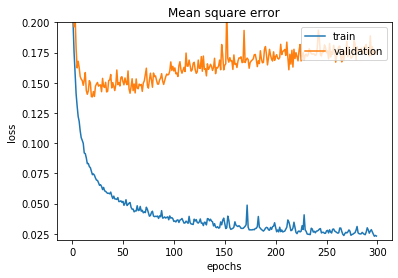

In [16]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.ylim(0.02, 0.2)
plt.title('Mean square error')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')

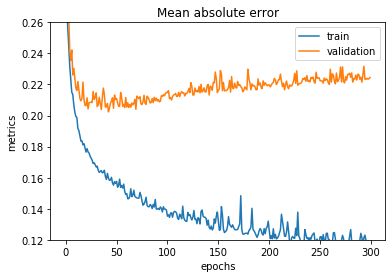

In [17]:
plt.plot(history.history['mean_absolute_error'], label='train')
plt.plot(history.history['val_mean_absolute_error'], label='validation')
plt.ylim(0.12, 0.26)
plt.title('Mean absolute error')
plt.ylabel('metrics')
plt.xlabel('epochs')
plt.legend(loc='upper right')

測試數據的誤差百分比：用測試數據預測房屋價格並與答案計算誤差百分比。

In [18]:
# 載入模型
model = keras.models.load_model('lab2-logs/models/Best-model-1.h5')
# 先將房屋價格取出
y_test = np.array(test_data['price'])
# 標準化數據
test_data = (test_data - mean) / std
# 將輸入數據存成Numpy 格式
x_test = np.array(test_data.drop('price', axis='columns'))
# 預測測試數據
y_pred = model.predict(x_test)
# 將預測結果轉換回來(因為訓練時的訓練目標也有經過標準化)
y_pred = np.reshape(y_pred * std['price'] + mean['price'], y_test.shape)
# 計算平均的誤差百分比
percentage_error = np.mean(np.abs(y_test - y_pred)) / np.mean(y_test) * 100
# 顯示誤差百分比
print("Model_1 Percentage Error: {:.2f}%".format(percentage_error))

Model_1 Percentage Error: 13.67%


### TensorBoard 可視化工具

In [19]:
# 這行指令可以幫助我們直接在jupyter notebook上顯示TensorBoard
%load_ext tensorboard

In [20]:
%tensorboard --port 9530 --logdir lab2-logs

Reusing TensorBoard on port 9530 (pid 8108), started 0:11:33 ago. (Use '!kill 8108' to kill it.)

# 實驗二：過擬合問題

### 方法一、減少網路權重

In [21]:
model_2 = keras.Sequential(name='model-2')
model_2.add(layers.Dense(16, activation='relu', input_shape=(21,)))
model_2.add(layers.Dense(16, activation='relu'))
model_2.add(layers.Dense(1))

model_2.compile(keras.optimizers.Adam(0.001),
                loss=keras.losses.MeanSquaredError(),
                metrics=[keras.metrics.MeanAbsoluteError()])

log_dir = os.path.join('lab2-logs', 'model-2')
model_cbk = keras.callbacks.TensorBoard(log_dir=log_dir)
model_mckp = keras.callbacks.ModelCheckpoint(model_dir + '/Best-model-2.h5', 
                                             monitor='val_mean_absolute_error', 
                                             save_best_only=True, 
                                             mode='min')
model_2.fit(x_train, y_train, 
            batch_size=64 ,
            epochs=300, 
            validation_data=(x_val, y_val), 
            callbacks=[model_cbk, model_mckp])

Train on 12967 samples, validate on 4323 samples
Epoch 1/300
12967/12967 [==============================] - 1s 97us/sample - loss: 0.4805 - mean_absolute_error: 0.4246 - val_loss: 0.3289 - val_mean_absolute_error: 0.3453
Epoch 2/300
12967/12967 [==============================] - 1s 41us/sample - loss: 0.2553 - mean_absolute_error: 0.3133 - val_loss: 0.2718 - val_mean_absolute_error: 0.3221
Epoch 3/300
12967/12967 [==============================] - 0s 36us/sample - loss: 0.2239 - mean_absolute_error: 0.2956 - val_loss: 0.2486 - val_mean_absolute_error: 0.3046
Epoch 4/300
12967/12967 [==============================] - 0s 35us/sample - loss: 0.2082 - mean_absolute_error: 0.2841 - val_loss: 0.2426 - val_mean_absolute_error: 0.2928
Epoch 5/300
12967/12967 [==============================] - 0s 36us/sample - loss: 0.1953 - mean_absolute_error: 0.2747 - val_loss: 0.2213 - val_mean_absolute_error: 0.2850
Epoch 6/300
12967/12967 [==============================] - 0s 34us/sample - loss: 0.1864 - 

12967/12967 [==============================] - 0s 30us/sample - loss: 0.0828 - mean_absolute_error: 0.1847 - val_loss: 0.1491 - val_mean_absolute_error: 0.2154
Epoch 96/300
12967/12967 [==============================] - 0s 30us/sample - loss: 0.0837 - mean_absolute_error: 0.1852 - val_loss: 0.1345 - val_mean_absolute_error: 0.2081
Epoch 97/300
12967/12967 [==============================] - 0s 30us/sample - loss: 0.0819 - mean_absolute_error: 0.1839 - val_loss: 0.1390 - val_mean_absolute_error: 0.2079
Epoch 98/300
12967/12967 [==============================] - 0s 30us/sample - loss: 0.0817 - mean_absolute_error: 0.1831 - val_loss: 0.1358 - val_mean_absolute_error: 0.2102
Epoch 99/300
12967/12967 [==============================] - 0s 30us/sample - loss: 0.0820 - mean_absolute_error: 0.1838 - val_loss: 0.1377 - val_mean_absolute_error: 0.2104
Epoch 100/300
12967/12967 [==============================] - 0s 30us/sample - loss: 0.0817 - mean_absolute_error: 0.1838 - val_loss: 0.1384 - val_me

12967/12967 [==============================] - 0s 31us/sample - loss: 0.0734 - mean_absolute_error: 0.1780 - val_loss: 0.1402 - val_mean_absolute_error: 0.2071
Epoch 190/300
12967/12967 [==============================] - 0s 33us/sample - loss: 0.0737 - mean_absolute_error: 0.1777 - val_loss: 0.1511 - val_mean_absolute_error: 0.2111
Epoch 191/300
12967/12967 [==============================] - 0s 31us/sample - loss: 0.0737 - mean_absolute_error: 0.1780 - val_loss: 0.1426 - val_mean_absolute_error: 0.2094
Epoch 192/300
12967/12967 [==============================] - 0s 31us/sample - loss: 0.0735 - mean_absolute_error: 0.1784 - val_loss: 0.1421 - val_mean_absolute_error: 0.2105
Epoch 193/300
12967/12967 [==============================] - 0s 31us/sample - loss: 0.0739 - mean_absolute_error: 0.1784 - val_loss: 0.1417 - val_mean_absolute_error: 0.2102
Epoch 194/300
12967/12967 [==============================] - 0s 31us/sample - loss: 0.0735 - mean_absolute_error: 0.1782 - val_loss: 0.1380 - va

12967/12967 [==============================] - 0s 36us/sample - loss: 0.0683 - mean_absolute_error: 0.1741 - val_loss: 0.1398 - val_mean_absolute_error: 0.2059
Epoch 284/300
12967/12967 [==============================] - 0s 31us/sample - loss: 0.0689 - mean_absolute_error: 0.1743 - val_loss: 0.1403 - val_mean_absolute_error: 0.2068
Epoch 285/300
12967/12967 [==============================] - 0s 30us/sample - loss: 0.0676 - mean_absolute_error: 0.1732 - val_loss: 0.1401 - val_mean_absolute_error: 0.2059
Epoch 286/300
12967/12967 [==============================] - 0s 32us/sample - loss: 0.0685 - mean_absolute_error: 0.1744 - val_loss: 0.1385 - val_mean_absolute_error: 0.2050
Epoch 287/300
12967/12967 [==============================] - 0s 30us/sample - loss: 0.0685 - mean_absolute_error: 0.1744 - val_loss: 0.1453 - val_mean_absolute_error: 0.2096
Epoch 288/300
12967/12967 [==============================] - 0s 30us/sample - loss: 0.0686 - mean_absolute_error: 0.1741 - val_loss: 0.1396 - va

### 加入L1或L2 正則化

In [22]:
model_3 = keras.Sequential(name='model-3')
model_3.add(layers.Dense(64, 
                         kernel_regularizer=keras.regularizers.l2(0.001), 
                         activation='relu', input_shape=(21,)))
model_3.add(layers.Dense(64, kernel_regularizer=keras.regularizers.l2(0.001), activation='relu'))
model_3.add(layers.Dense(1))

model_3.compile(keras.optimizers.Adam(0.001),
                loss=keras.losses.MeanSquaredError(),
                metrics=[keras.metrics.MeanAbsoluteError()])

log_dir = os.path.join('lab2-logs', 'model-3')
model_cbk = keras.callbacks.TensorBoard(log_dir=log_dir)
model_mckp = keras.callbacks.ModelCheckpoint(model_dir + '/Best-model-3.h5', 
                                             monitor='val_mean_absolute_error', 
                                             save_best_only=True, 
                                             mode='min')
model_3.fit(x_train, y_train, 
            batch_size=64 ,
            epochs=300, 
            validation_data=(x_val, y_val), 
            callbacks=[model_cbk, model_mckp])

Train on 12967 samples, validate on 4323 samples
Epoch 1/300
12967/12967 [==============================] - 1s 98us/sample - loss: 0.3826 - mean_absolute_error: 0.3393 - val_loss: 0.3290 - val_mean_absolute_error: 0.2963
Epoch 2/300
12967/12967 [==============================] - 0s 37us/sample - loss: 0.2858 - mean_absolute_error: 0.2791 - val_loss: 0.2955 - val_mean_absolute_error: 0.2822
Epoch 3/300
12967/12967 [==============================] - 1s 39us/sample - loss: 0.2540 - mean_absolute_error: 0.2632 - val_loss: 0.2761 - val_mean_absolute_error: 0.2700
Epoch 4/300
12967/12967 [==============================] - 0s 38us/sample - loss: 0.2368 - mean_absolute_error: 0.2520 - val_loss: 0.2734 - val_mean_absolute_error: 0.2671
Epoch 5/300
12967/12967 [==============================] - 0s 36us/sample - loss: 0.2212 - mean_absolute_error: 0.2427 - val_loss: 0.2591 - val_mean_absolute_error: 0.2530
Epoch 6/300
12967/12967 [==============================] - 1s 39us/sample - loss: 0.2063 - 

12967/12967 [==============================] - 0s 33us/sample - loss: 0.0844 - mean_absolute_error: 0.1658 - val_loss: 0.1499 - val_mean_absolute_error: 0.1973
Epoch 96/300
12967/12967 [==============================] - 0s 34us/sample - loss: 0.0880 - mean_absolute_error: 0.1683 - val_loss: 0.1813 - val_mean_absolute_error: 0.2019
Epoch 97/300
12967/12967 [==============================] - 0s 34us/sample - loss: 0.0902 - mean_absolute_error: 0.1704 - val_loss: 0.1533 - val_mean_absolute_error: 0.2085
Epoch 98/300
12967/12967 [==============================] - 0s 33us/sample - loss: 0.0869 - mean_absolute_error: 0.1674 - val_loss: 0.1545 - val_mean_absolute_error: 0.2020
Epoch 99/300
12967/12967 [==============================] - 0s 33us/sample - loss: 0.0884 - mean_absolute_error: 0.1682 - val_loss: 0.1508 - val_mean_absolute_error: 0.1959
Epoch 100/300
12967/12967 [==============================] - 0s 34us/sample - loss: 0.0865 - mean_absolute_error: 0.1667 - val_loss: 0.1560 - val_me

12967/12967 [==============================] - 0s 34us/sample - loss: 0.0784 - mean_absolute_error: 0.1631 - val_loss: 0.1464 - val_mean_absolute_error: 0.1958
Epoch 190/300
12967/12967 [==============================] - 0s 34us/sample - loss: 0.0745 - mean_absolute_error: 0.1589 - val_loss: 0.1525 - val_mean_absolute_error: 0.1973
Epoch 191/300
12967/12967 [==============================] - 0s 34us/sample - loss: 0.0741 - mean_absolute_error: 0.1589 - val_loss: 0.1507 - val_mean_absolute_error: 0.1988
Epoch 192/300
12967/12967 [==============================] - 0s 35us/sample - loss: 0.0719 - mean_absolute_error: 0.1571 - val_loss: 0.1533 - val_mean_absolute_error: 0.1953
Epoch 193/300
12967/12967 [==============================] - 0s 33us/sample - loss: 0.0747 - mean_absolute_error: 0.1600 - val_loss: 0.1498 - val_mean_absolute_error: 0.1993
Epoch 194/300
12967/12967 [==============================] - 0s 36us/sample - loss: 0.0735 - mean_absolute_error: 0.1578 - val_loss: 0.1542 - va

Epoch 236/300
12967/12967 [==============================] - 0s 34us/sample - loss: 0.0701 - mean_absolute_error: 0.1557 - val_loss: 0.1486 - val_mean_absolute_error: 0.1959
Epoch 237/300
12967/12967 [==============================] - 0s 34us/sample - loss: 0.0698 - mean_absolute_error: 0.1544 - val_loss: 0.1522 - val_mean_absolute_error: 0.2017
Epoch 238/300
12967/12967 [==============================] - 0s 34us/sample - loss: 0.0770 - mean_absolute_error: 0.1614 - val_loss: 0.1759 - val_mean_absolute_error: 0.2119
Epoch 239/300
12967/12967 [==============================] - 0s 33us/sample - loss: 0.0821 - mean_absolute_error: 0.1658 - val_loss: 0.1489 - val_mean_absolute_error: 0.2000
Epoch 240/300
12967/12967 [==============================] - 0s 35us/sample - loss: 0.0732 - mean_absolute_error: 0.1580 - val_loss: 0.1435 - val_mean_absolute_error: 0.1927
Epoch 241/300
12967/12967 [==============================] - 0s 35us/sample - loss: 0.0705 - mean_absolute_error: 0.1553 - val_los

### 加入 Dropout

In [23]:
model_4 = keras.Sequential(name='model-4')
model_4.add(layers.Dense(64, activation='relu', input_shape=(21,)))
model_4.add(layers.Dropout(0.3))
model_4.add(layers.Dense(64, activation='relu'))
model_4.add(layers.Dropout(0.3))
model_4.add(layers.Dense(1))

model_4.compile(keras.optimizers.Adam(0.001),
                loss=keras.losses.MeanSquaredError(),
                metrics=[keras.metrics.MeanAbsoluteError()])

log_dir = os.path.join('lab2-logs', 'model-4')
model_cbk = keras.callbacks.TensorBoard(log_dir=log_dir)
model_mckp = keras.callbacks.ModelCheckpoint(model_dir + '/Best-model-4.h5', 
                                             monitor='val_mean_absolute_error', 
                                             save_best_only=True, 
                                             mode='min')
model_4.fit(x_train, y_train, 
            batch_size=64 ,
            epochs=300, 
            validation_data=(x_val, y_val), 
            callbacks=[model_cbk, model_mckp])

Train on 12967 samples, validate on 4323 samples
Epoch 1/300
12967/12967 [==============================] - 1s 103us/sample - loss: 0.4961 - mean_absolute_error: 0.4525 - val_loss: 0.2910 - val_mean_absolute_error: 0.3177
Epoch 2/300
12967/12967 [==============================] - 1s 48us/sample - loss: 0.3170 - mean_absolute_error: 0.3530 - val_loss: 0.2722 - val_mean_absolute_error: 0.3123
Epoch 3/300
12967/12967 [==============================] - 1s 48us/sample - loss: 0.2827 - mean_absolute_error: 0.3307 - val_loss: 0.2299 - val_mean_absolute_error: 0.2939
Epoch 4/300
12967/12967 [==============================] - 1s 47us/sample - loss: 0.2666 - mean_absolute_error: 0.3152 - val_loss: 0.2148 - val_mean_absolute_error: 0.2880
Epoch 5/300
12967/12967 [==============================] - 1s 50us/sample - loss: 0.2430 - mean_absolute_error: 0.3046 - val_loss: 0.2287 - val_mean_absolute_error: 0.2827
Epoch 6/300
12967/12967 [==============================] - 1s 48us/sample - loss: 0.2124 -

12967/12967 [==============================] - 1s 45us/sample - loss: 0.1208 - mean_absolute_error: 0.2229 - val_loss: 0.1472 - val_mean_absolute_error: 0.2237
Epoch 96/300
12967/12967 [==============================] - 1s 45us/sample - loss: 0.1155 - mean_absolute_error: 0.2195 - val_loss: 0.1460 - val_mean_absolute_error: 0.2332
Epoch 97/300
12967/12967 [==============================] - 1s 45us/sample - loss: 0.1195 - mean_absolute_error: 0.2206 - val_loss: 0.1409 - val_mean_absolute_error: 0.2149
Epoch 98/300
12967/12967 [==============================] - 1s 44us/sample - loss: 0.1213 - mean_absolute_error: 0.2203 - val_loss: 0.1435 - val_mean_absolute_error: 0.2213
Epoch 99/300
12967/12967 [==============================] - 1s 45us/sample - loss: 0.1109 - mean_absolute_error: 0.2176 - val_loss: 0.1467 - val_mean_absolute_error: 0.2314
Epoch 100/300
12967/12967 [==============================] - 1s 44us/sample - loss: 0.1094 - mean_absolute_error: 0.2153 - val_loss: 0.1315 - val_me

12967/12967 [==============================] - 1s 45us/sample - loss: 0.1120 - mean_absolute_error: 0.2132 - val_loss: 0.1495 - val_mean_absolute_error: 0.2300
Epoch 190/300
12967/12967 [==============================] - 1s 45us/sample - loss: 0.1090 - mean_absolute_error: 0.2116 - val_loss: 0.1433 - val_mean_absolute_error: 0.2293
Epoch 191/300
12967/12967 [==============================] - 1s 46us/sample - loss: 0.1099 - mean_absolute_error: 0.2114 - val_loss: 0.1564 - val_mean_absolute_error: 0.2363
Epoch 192/300
12967/12967 [==============================] - 1s 45us/sample - loss: 0.1049 - mean_absolute_error: 0.2109 - val_loss: 0.1440 - val_mean_absolute_error: 0.2210
Epoch 193/300
12967/12967 [==============================] - 1s 45us/sample - loss: 0.0999 - mean_absolute_error: 0.2082 - val_loss: 0.1535 - val_mean_absolute_error: 0.2264
Epoch 194/300
12967/12967 [==============================] - 1s 45us/sample - loss: 0.1018 - mean_absolute_error: 0.2103 - val_loss: 0.1287 - va

Epoch 283/300
12967/12967 [==============================] - 1s 45us/sample - loss: 0.1049 - mean_absolute_error: 0.2096 - val_loss: 0.1531 - val_mean_absolute_error: 0.2252
Epoch 284/300
12967/12967 [==============================] - 1s 44us/sample - loss: 0.1012 - mean_absolute_error: 0.2093 - val_loss: 0.1369 - val_mean_absolute_error: 0.2166
Epoch 285/300
12967/12967 [==============================] - 1s 47us/sample - loss: 0.1052 - mean_absolute_error: 0.2099 - val_loss: 0.1370 - val_mean_absolute_error: 0.2261
Epoch 286/300
12967/12967 [==============================] - 1s 45us/sample - loss: 0.1021 - mean_absolute_error: 0.2085 - val_loss: 0.1347 - val_mean_absolute_error: 0.2201
Epoch 287/300
12967/12967 [==============================] - 1s 45us/sample - loss: 0.0993 - mean_absolute_error: 0.2085 - val_loss: 0.1493 - val_mean_absolute_error: 0.2267
Epoch 288/300
12967/12967 [==============================] - 1s 45us/sample - loss: 0.1064 - mean_absolute_error: 0.2124 - val_los

### 驗證正則化的效能

Test model 2:

In [24]:
model_2 = keras.models.load_model('lab2-logs/models/Best-model-2.h5')
y_pred = model_2.predict(x_test)
y_pred = np.reshape(y_pred * std['price'] + mean['price'], y_test.shape)
percentage_error = np.mean(np.abs(y_test - y_pred)) / np.mean(y_test) * 100
print("Model_2: {:.2f}%".format(percentage_error))

Model_2: 13.61%


Test model 3:

In [25]:
model_3 = keras.models.load_model('lab2-logs/models/Best-model-3.h5')
y_pred = model_3.predict(x_test)
y_pred = np.reshape(y_pred * std['price'] + mean['price'], y_test.shape)
percentage_error = np.mean(np.abs(y_test - y_pred)) / np.mean(y_test) * 100
print("Model_3: {:.2f}%".format(percentage_error))

Model_3: 12.90%


Test model 4:

In [26]:
model_4 = keras.models.load_model('lab2-logs/models/Best-model-4.h5')
y_pred = model_4.predict(x_test)
y_pred = np.reshape(y_pred * std['price'] + mean['price'], y_test.shape)
percentage_error = np.mean(np.abs(y_test - y_pred)) / np.mean(y_test) * 100
print("Model_4: {:.2f}%".format(percentage_error))

Model_4: 13.98%
